### Imports

In [544]:
import pandas as pd
import requests
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import haversine_distances

# Figure Out Which Park I Will Go Hiking in For an August Vacation
## Based on:
- **Preference for National Parks**
- **Driving Distance**
- **Expected Weather**

---

## Get List of Every Park Run By the NPS  in the US
- helpful documentation: https://www.nps.gov/subjects/developer/api-documentation.htm#/

In [225]:
def get_nps_park_info():
    
    # API endpoint for the National Park Service API
    endpoint = 'parks'
    API_ENDPOINT = f"https://developer.nps.gov/api/v1/{endpoint}"

    # API key for accessing the National Park Service API
    API_KEY = 'kdwYf9g5hjZpiFLxsM8bhkGExV9rIvznz43qcmwO'

    # Request parameters
    params = {
        'api_key': API_KEY,
        'limit': 1000,  # Maximum number of parks per request
        'countryCode': 'US',  # Limit results to US parks
    }

    # Send initial GET request to the API
    response = requests.get(API_ENDPOINT, params=params)
    data = response.json()

    # Check if the request was successful
    if response.status_code == 200:

        # Retrieve the list of parks from the initial response
        parks = data['data']
        return parks
    
    else:
        print(response.status_code)
        return None

In [235]:
def filter_nps_park_info(parks):
    # Iterate over each park
    park_info = []
    for park in parks:
        
        # Only keep parks where I can go hiking
        has_hiking = [True if activity['name'] == 'Hiking' else False for activity in park['activities']]
        if not has_hiking:
            continue

        # Save helpful information on park
        park_info.append([park['fullName'], park['latitude'], park['longitude'], park['states'], park['designation']])
    
    return park_info

In [236]:
def format_and_clean_nps_park_info(park_info):
    cols = ['park', 'lat', 'lon', 'states', 'park_type']
    types = ['str', 'float', 'float', 'str', 'str']
    
    df = pd.DataFrame(park_info, columns=cols)
    
    clean_df = df.replace('', float('nan')).dropna()
    typed_df = clean_df.astype(dict(zip(cols, types)))
    
    return typed_df

In [240]:
parks_api_call = get_nps_park_info()
nps_parks = format_and_clean_nps_park_info(filter_nps_park_info(parks_api_call))
nps_national_parks = nps_parks[nps_parks['park_type'] == 'National Park'].reset_index(drop=True)

---

## Get Distance From Home Metric and Filter Out Parks
- distance = miles away as the crow flies
- calculated using latitude/longitude to save computation time

#### Add Distance From Home

In [432]:
def latitude_longitude_distance(start_location, end_location, earths_radius_in_miles=6371/1.609344):
    # Turn latitude/longitude into radians
    start_location = np.deg2rad(start_location)
    end_location = np.deg2rad(end_location)
    
    # Get the distance between that start location(s) and end location(s) in miles
    return haversine_distances(start_location, end_location) * earths_radius_in_miles

In [433]:
home = [[33.822460, -84.328970]]
nps_parks['dist'] = latitude_longitude_distance(nps_parks[['lat', 'lon']], home)
nps_national_parks['dist'] = latitude_longitude_distance(nps_national_parks[['lat', 'lon']], home)

#### Filter Out Parks by Distance from Home

In [437]:
nps_parks_of_interest = nps_parks[nps_parks['dist'] < 800]

---

## Get Daily Expected Weather and Filter Out Parks

### Definition: Expected Weather 
- The daily weather averaged over the past ~10 years for a given month-day pair

### Helpful Documentation
- https://open-meteo.com/en/docs

### Variables of Interest
- temperature_2m = Air temperature °F at 2 meters above ground
- apparent_temperature = Perceived feels-like temperature °F combining wind chill factor, relative humidity and solar radiation 

### Sources that didnt work (due to cost or ambiguities)
- OpenWeatherMap (paid)
- Tomorrow.io (paid)
- NCEI (zipcode ambiguity) https://www.ncei.noaa.gov/cdo-web/search?datasetid=NORMAL_DLY
- meteostat (doesn't have weather for most "National Parks")

### Possible Add-Ons
- Check out current literature on forecasting weather to look into a better way to calculate or learn expected weather.

#### Add Expected Weather Per Park

In [254]:
def format_date(year, month, day):
    return f"{year}-{'{:02d}'.format(month)}-{'{:02d}'.format(day)}"

In [515]:
# May return an empty dataframe
def daily_weather(lat, lon, start_year, start_month, start_day, end_year, end_month, end_day):
    
    # Construct the request URL
    start_date = format_date(start_year, start_month, start_day)
    end_date = format_date(end_year, end_month, end_day)
    daily_weather_variables = 'temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min'

    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}&daily={daily_weather_variables}&timezone=America%2FNew_York&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch"

    # Construct the request Header
    headers = {}
    headers["Content-Type"] = "multipart/form-data"
    headers["Accept"] = "application/json"

    # Send the API request
    response = requests.get(url, headers=headers)
    
    # Parse the JSON response
    json = response.json()
    
    # Format Data as a DataFrame
    df = pd.DataFrame(json['daily']).astype({'time':'datetime64'})
    return df

In [362]:
def daily_weather_averaged_over_years(lat, lon, start_year, start_month, start_day, end_year, end_month, end_day):
    
    # Get weather data for multiple years and concatenate them into 1 dataframe
    data = pd.concat([daily_weather(lat, lon, year, start_month, start_day, year, end_month, end_day) 
                      for year in range(start_year, end_year + 1)])

    # Get the average daily weather over the years
    avg_data = data.groupby([data.time.dt.month, data.time.dt.day]).agg('mean')
    avg_data.index = avg_data.index.rename(['month', 'day'])
    
    # Form a pivot table
    return avg_data.reset_index()

In [397]:
def daily_park_weather_averaged_over_years(park, *dates_info):
    
    # Get the average weather for the given month(s)/day(s) range
    df = daily_weather_averaged_over_years(park['lat'], park['lon'], *dates_info)
    
    # Add Park Information To All Rows
    df[park.index] = park
    
    return df

In [438]:
start_year = 2010
end_year = 2022
month = 8
start_day = 9
end_day = 20
dates_info = [start_year, month, start_day, end_year, month, end_day]

# Get the expected weather for all national parks for the chosen dates.
nps_parks_of_interest_weather = pd.concat(nps_parks_of_interest.apply(lambda park: daily_park_weather_averaged_over_years(park, *dates_info), axis=1).to_list()).reset_index(drop=True)

#### Filter Out Parks by Expected Weather

In [456]:
# Keep park-date pairs that have cool temperatures
is_cool_temp = nps_parks_of_interest_weather['apparent_temperature_max'] <= 77
cool_temp_driving_dist_parks = nps_parks_of_interest_weather[is_cool_temp].sort_values('dist')

In [469]:
# Counts the number of days with cool temperatures for each park
parks_num_of_days_with_cool_temp = cool_temp_driving_dist_parks.groupby('park')['park'].count()

# Must have at least 4 days of cool weather since thats about how long our vacation will be
final_parks = parks_num_of_days_with_cool_temp[parks_num_of_days_with_cool_temp >= 4].index.to_list()

----

## Final List of Possible Parks

In [470]:
nps_parks[nps_parks['park'].isin(final_parks)]

,park,lat,lon,states,park_type,dist
11,Allegheny Portage Railroad National Historic Site,40.429775,-78.574316,PA,National Historic Site,555.497344
134,Flight 93 National Memorial,40.060615,-78.894569,PA,National Memorial,524.948560
394,Sleeping Bear Dunes National Lakeshore,44.928450,-86.027066,MI,National Lakeshore,772.640212


---

## August Vacation Location: Sleeping Bear Dunes National Lakeshore!!!
### Benefits:
- Cool weather
- Driving time is within the range we're willing to do (double checked on google maps by hand)
- Has plenty of hiking trails (checked on alltrails)

In [517]:
vacation_park = 'Sleeping Bear Dunes National Lakeshore'
vacation_park_weather = nps_parks_of_interest_weather[nps_parks_of_interest_weather['park'] == vacation_park]

Text(0, 0.5, 'Expected Temperature (°F)')

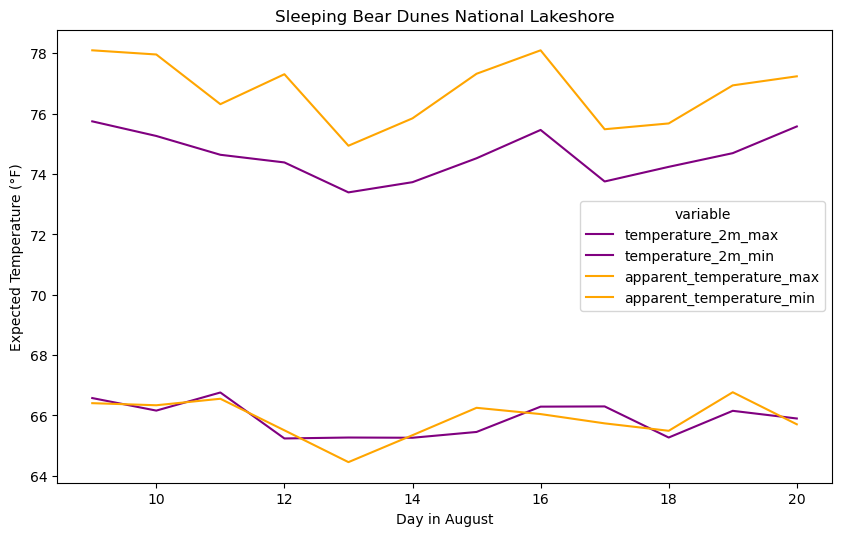

In [551]:
fig = plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')

keep_cols = vacation_park_weather.columns[1:6].to_list()
sns.lineplot(x='day', 
             y='value', 
             hue='variable', 
             data=pd.melt(vacation_park_weather[keep_cols], ['day']), 
             palette=['purple', 'purple', 'orange', 'orange'])

plt.title("Sleeping Bear Dunes National Lakeshore")
plt.xlabel("Day in August")
plt.ylabel("Expected Temperature (°F)")